In [111]:
#Nothing nowadays exhibits obvious cointegration that one can exploit 
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define stock pairs
candidates = [("PEP","KO"),("XOM", "CVX"), ("JPM", "BAC")]

start_date = "1985-01-01"
end_date = "1988-01-01"

# Store results
cointegration_results = {}

for (stock1, stock2) in candidates:
    print(f"\nChecking {stock1} vs {stock2}")
    df = yf.download([stock1, stock2], start=start_date, end=end_date)["Close"].dropna()
    score, p_value, _ = coint(df[stock1], df[stock2])
    cointegration_results[(stock1, stock2)] = [p_value]
# Convert results to a DataFrame for easy viewing
cointegration_df = pd.DataFrame(cointegration_results,index=["p-value"]).T
cointegration_df

[*********************100%***********************]  2 of 2 completed
[                       0%                       ]


Checking PEP vs KO

Checking XOM vs CVX


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Checking JPM vs BAC


,,p-value
PEP,KO,0.070556
XOM,CVX,0.949630
JPM,BAC,0.429373


[*********************100%***********************]  2 of 2 completed


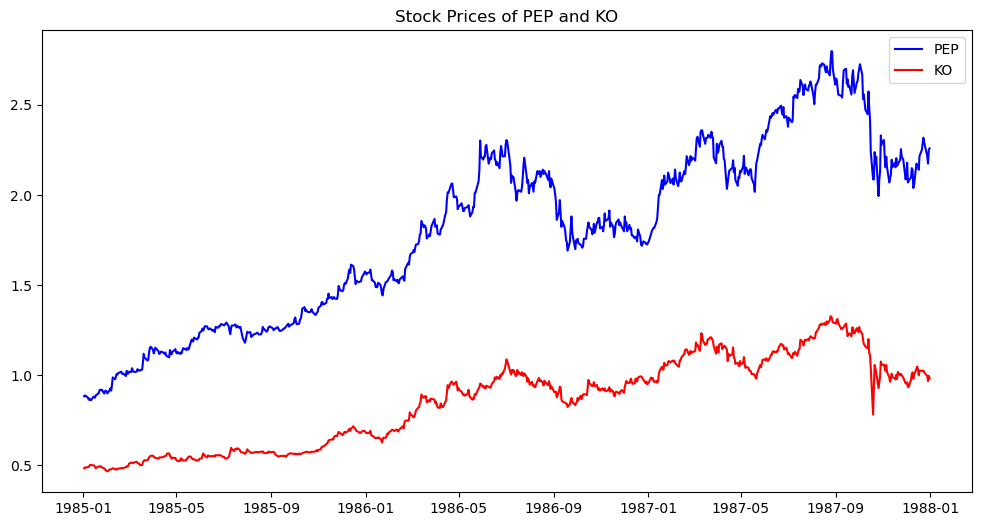

In [114]:


# Define stock pair
stock1, stock2 = "PEP","KO"

# Fetch last 2 years of data
start_date = "1985-01-01"
end_date = "1988-01-01"

data = yf.download([stock1, stock2], start=start_date, end=end_date)['Close'].dropna()

# Plot price data
plt.figure(figsize=(12,6))
plt.plot(data.index, data[stock1], label=stock1, color="blue")
plt.plot(data.index, data[stock2], label=stock2, color="red")
plt.legend()
plt.title("Stock Prices of PEP and KO")
plt.show()


In [188]:
start_date = "1980-01-01"
end_date = "1985-01-01"

warm_up_data = yf.download([stock1, stock2], start=start_date, end=end_date)['Close'].dropna()

[*********************100%***********************]  2 of 2 completed


C:\Users\piotr\AppData\Local\Temp\ipykernel_2416\3865611372.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio_ols = model_ols.params[1]
C:\Users\piotr\AppData\Local\Temp\ipykernel_2416\3865611372.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_ols   = model_ols.params[0]


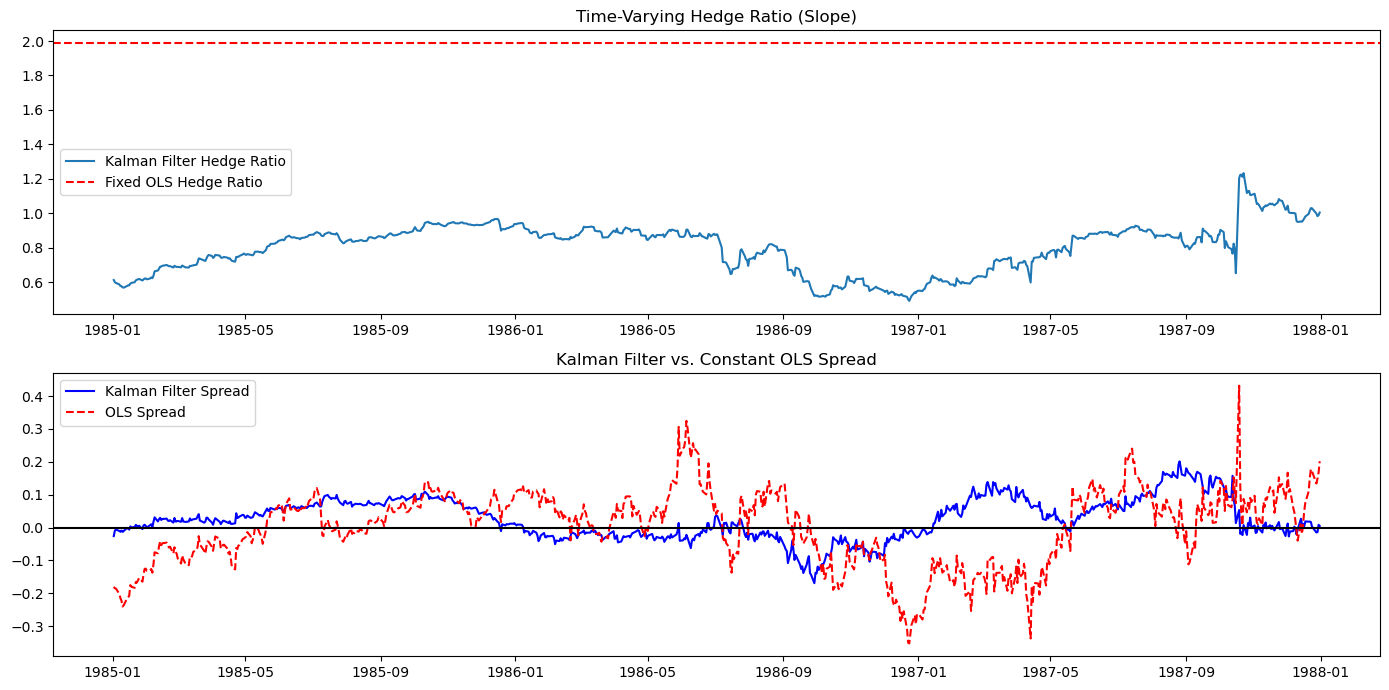

In [189]:
# We select TGT and WMT as they seem to be cointegrated recently. We will use mean reverint approach based on Z-scores.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import statsmodels.api as sm

# Define X (independent) and Y (dependent) variables
X = sm.add_constant(data[stock2])
y = data[stock1]
model_ols = sm.OLS(y, X).fit()
hedge_ratio_ols = model_ols.params[1]
intercept_ols   = model_ols.params[0]

data["Spread_OLS"] = data[stock1] - (hedge_ratio_ols * data[stock2] + intercept_ols)


# Observation matrix: [KO_t, 1] for the intercept
obs_mat = np.vstack([data['KO'], np.ones(len(data))]).T[:, np.newaxis, :]

kf = KalmanFilter(n_dim_obs=1,                                      # y is 1-dimensional
                  n_dim_state=2,                                    #  states (alpha, beta) is 2-dimensinal
                  initial_state_mean=np.ones(2),                    #  initial value of intercept and slope theta0|0
                  initial_state_covariance=10*np.ones((2, 2)),         # initial cov matrix between intercept and slope P0|0
                  transition_matrices=np.eye(2),                    # G, constant
                  observation_matrices=obs_mat,                   # F, depends on x
                  observation_covariance=1,                         # v_t, constant
                  transition_covariance= np.eye(2))

state_means, state_covs = kf.filter(data[stock1].values)
intercepts_kf = state_means[:, 0]
slopes_kf     = state_means[:, 1]

data["Hedge_Ratio_KF"] = slopes_kf
data["Intercept_KF"]   = intercepts_kf

# Calculate the spread

data["Spread_KF"] = data[stock1] - (slopes_kf * data[stock2] + intercepts_kf)

# Plot the results
plt.figure(figsize=(14,7))

plt.subplot(2,1,1)
plt.plot(data.index, data["Hedge_Ratio_KF"], label="Kalman Filter Hedge Ratio")
plt.axhline(hedge_ratio_ols, color='red', ls='--', label="Fixed OLS Hedge Ratio")
plt.title("Time-Varying Hedge Ratio (Slope)")
plt.legend()

plt.subplot(2,1,2)
plt.plot(data.index, data["Spread_KF"], label="Kalman Filter Spread", color='blue')
plt.plot(data.index, data["Spread_OLS"], label="OLS Spread", color='red', linestyle='--')
plt.title("Kalman Filter vs. Constant OLS Spread")
plt.axhline(0, color='black', linestyle='-')
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\piotr\AppData\Local\Temp\ipykernel_2416\3275029495.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expanding_hedge_ratios.append(model_sub.params[1])
C:\Users\piotr\AppData\Local\Temp\ipykernel_2416\3275029495.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expanding_intercepts.append(model_sub.params[0])
C:\Users\piotr\AppData\Local\Temp\ipykernel_2416\3275029495.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  

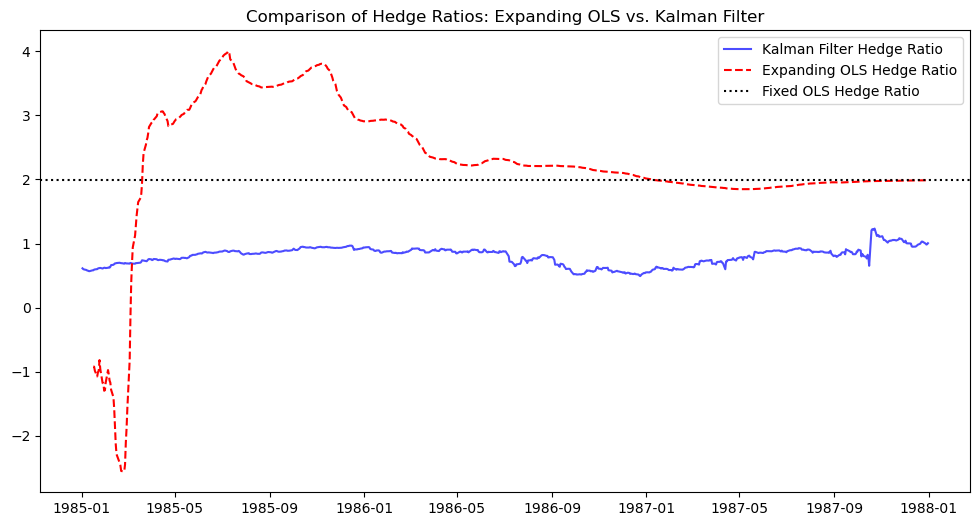

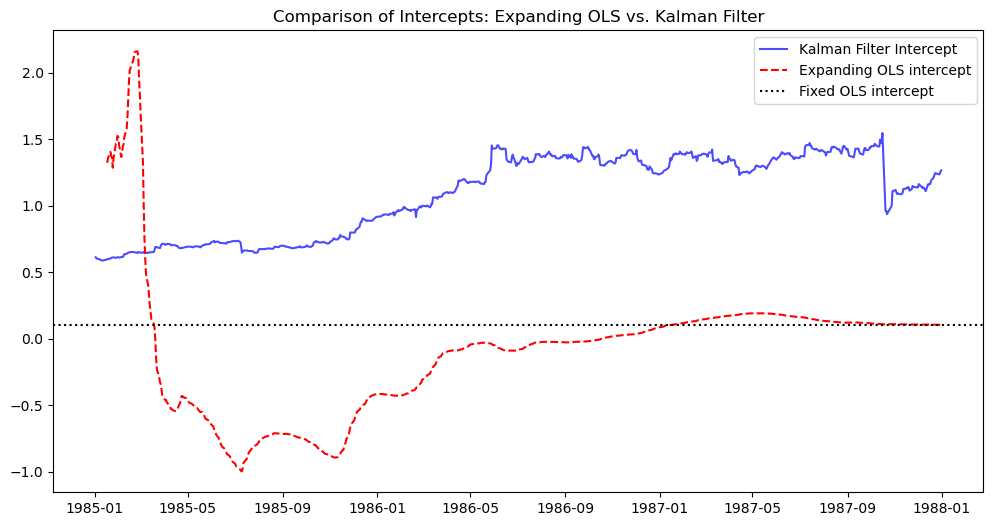

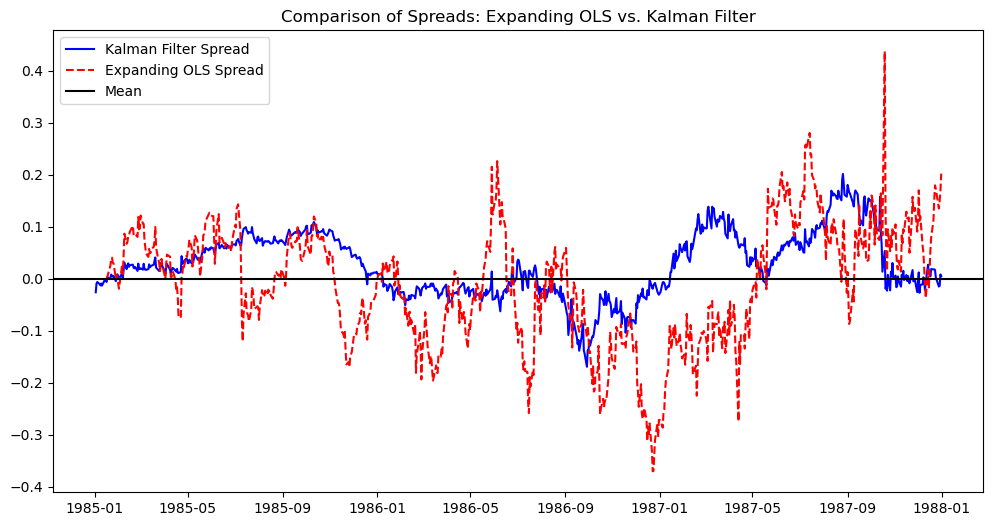

In [190]:
expanding_hedge_ratios = []
expanding_intercepts   = []

for t in range(10, len(data)):
    X_sub = sm.add_constant(data[stock2].iloc[:t])
    y_sub = data[stock1].iloc[:t]
    model_sub = sm.OLS(y_sub, X_sub).fit()
    expanding_hedge_ratios.append(model_sub.params[1])
    expanding_intercepts.append(model_sub.params[0])

data["Hedge_Ratio_ExpandingOLS"] = np.nan
data["Hedge_Ratio_ExpandingOLS"].iloc[10:] = expanding_hedge_ratios

data["Intercept_ExpandingOLS"] = np.nan
data["Intercept_ExpandingOLS"].iloc[10:] = expanding_intercepts

data["Spread_ExpandingOLS"] = data[stock1] - (
    data["Hedge_Ratio_ExpandingOLS"] * data[stock2] + data["Intercept_ExpandingOLS"]
)

# Plot Hedge Ratios: KF vs. Expanding OLS
plt.figure(figsize=(12,6))
plt.plot(data.index, data["Hedge_Ratio_KF"], label="Kalman Filter Hedge Ratio", color="blue", alpha=0.7)
plt.plot(data.index, data["Hedge_Ratio_ExpandingOLS"], label="Expanding OLS Hedge Ratio", color="red", linestyle="--")
plt.axhline(hedge_ratio_ols, color="black", linestyle="dotted", label="Fixed OLS Hedge Ratio")
plt.title("Comparison of Hedge Ratios: Expanding OLS vs. Kalman Filter")
plt.legend()
plt.show()
# Plot Hedge Ratios: KF vs. Expanding OLS
plt.figure(figsize=(12,6))
plt.plot(data.index, data["Intercept_KF"], label="Kalman Filter Intercept", color="blue", alpha=0.7)
plt.plot(data.index, data["Intercept_ExpandingOLS"], label="Expanding OLS intercept", color="red", linestyle="--")
plt.axhline(intercept_ols, color="black", linestyle="dotted", label="Fixed OLS intercept")
plt.title("Comparison of Intercepts: Expanding OLS vs. Kalman Filter")
plt.legend()
plt.show()

# Plot Spreads: KF vs. Expanding OLS
plt.figure(figsize=(12,6))
plt.plot(data.index, data["Spread_KF"], label="Kalman Filter Spread", color="blue")
plt.plot(data.index, data["Spread_ExpandingOLS"], label="Expanding OLS Spread", color="red", linestyle="--")
plt.axhline(0, color="black", linestyle="-", label="Mean")
plt.legend()
plt.title("Comparison of Spreads: Expanding OLS vs. Kalman Filter")
plt.show()


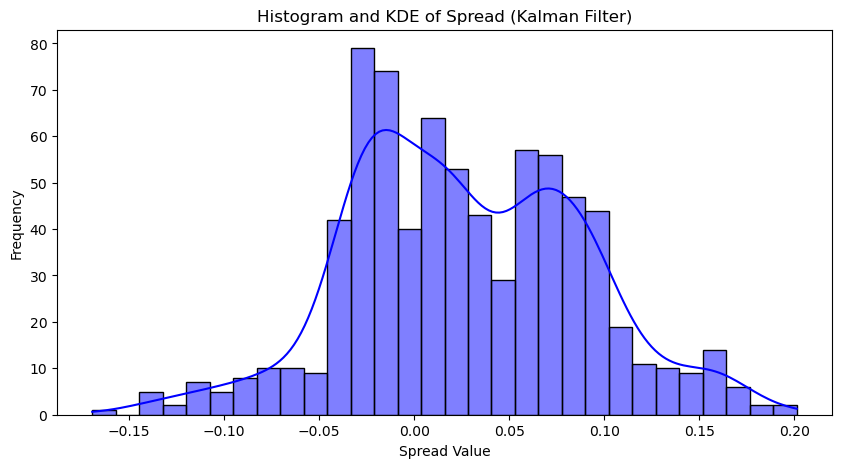

Shapiro-Wilk p-value: 0.0000
Jarque-Bera p-value:  0.6947
❌ The spread does NOT appear normally distributed.


In [191]:
spread_values = data["Spread_KF"].dropna()
shapiro_test = stats.shapiro(spread_values)
jb_test = stats.jarque_bera(spread_values)

plt.figure(figsize=(10,5))
sns.histplot(spread_values, kde=True, bins=30, color="blue")
plt.title("Histogram and KDE of Spread (Kalman Filter)")
plt.xlabel("Spread Value")
plt.ylabel("Frequency")
plt.show()

print(f"Shapiro-Wilk p-value: {shapiro_test.pvalue:.4f}")
print(f"Jarque-Bera p-value:  {jb_test[1]:.4f}")

if (shapiro_test.pvalue > 0.05) and (jb_test[1] > 0.05):
    print("✅ The spread appears normally distributed.")
else:
    print("❌ The spread does NOT appear normally distributed.")


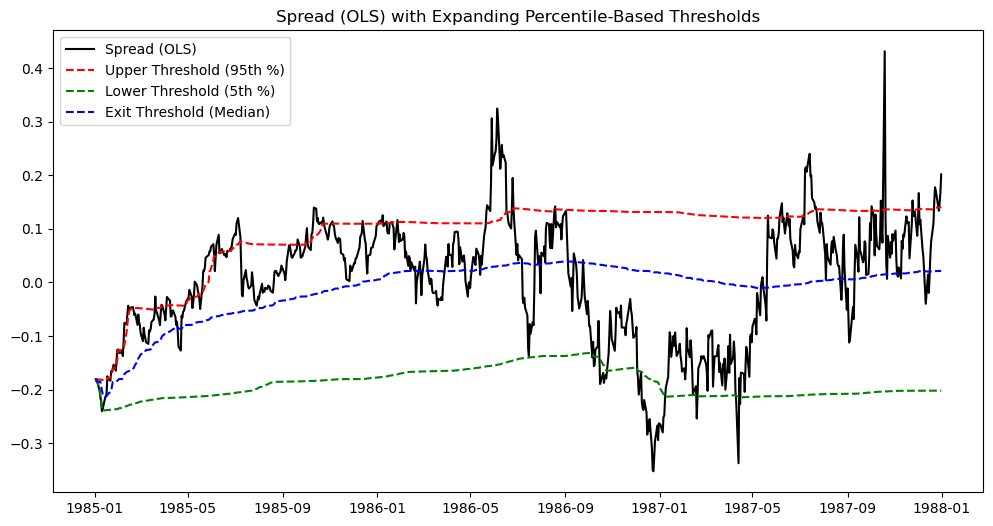

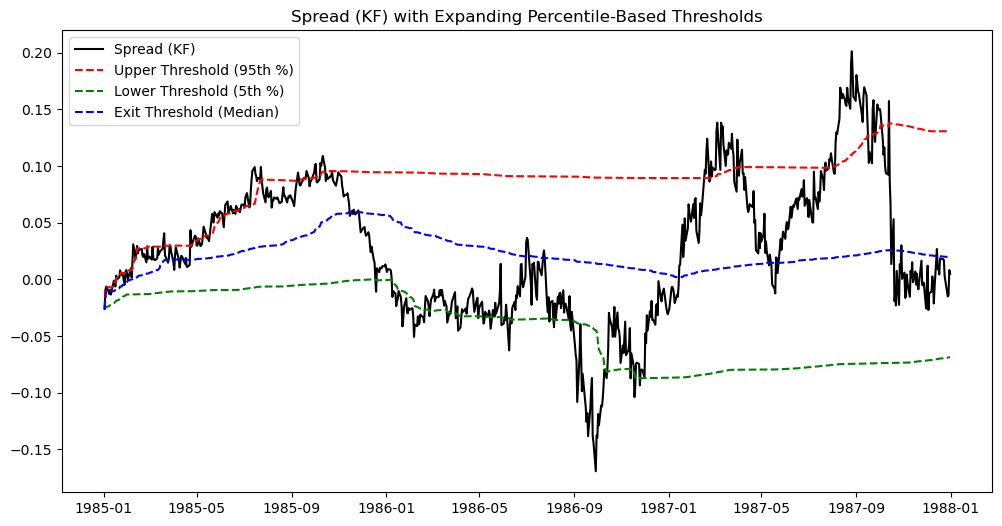

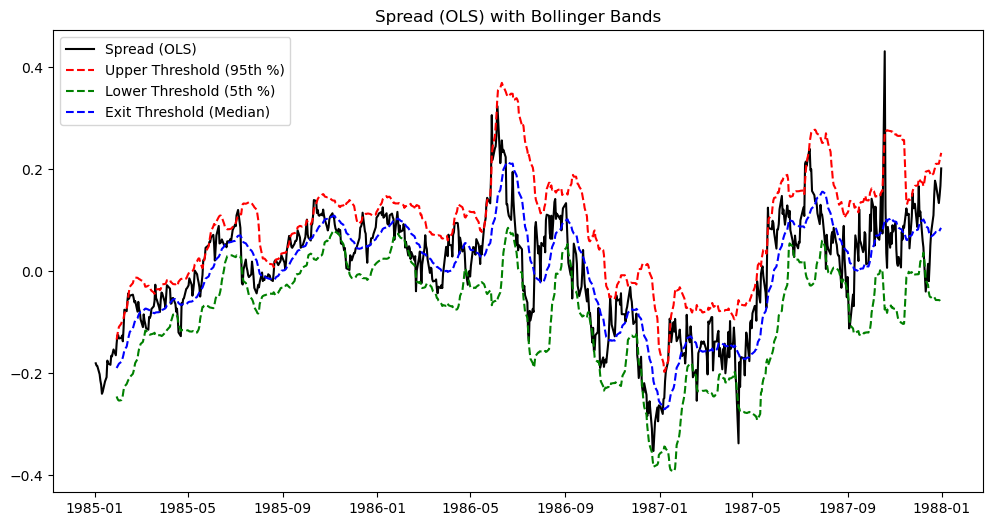

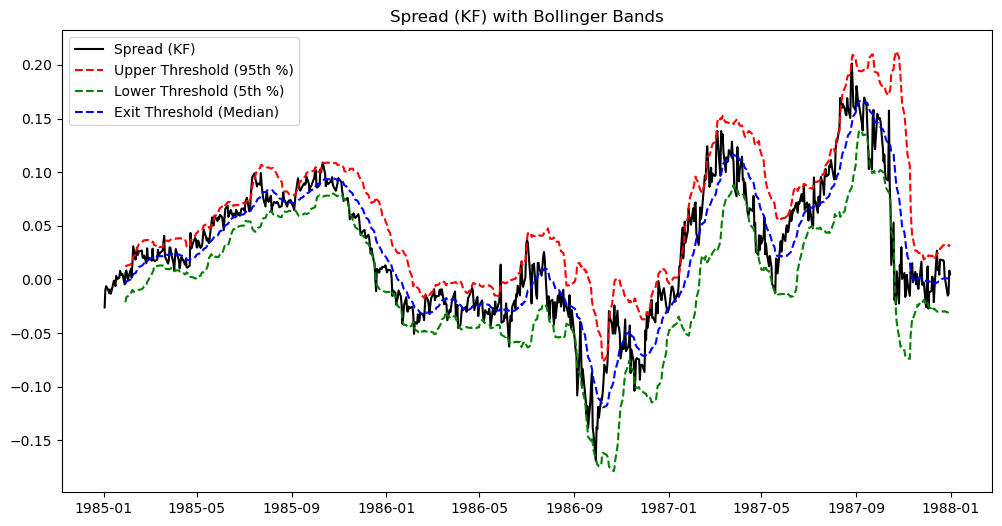

In [192]:


data['QT_Upper_OLS'] = data['Spread_OLS'].expanding().quantile(0.95)
data['QT_Lower_OLS'] = data['Spread_OLS'].expanding().quantile(0.05)
data['QT_Exit_OLS']  = data['Spread_OLS'].expanding().quantile(0.50)

plt.figure(figsize=(12,6))
plt.plot(data.index, data['Spread_OLS'], label='Spread (OLS)', color='black')
plt.plot(data.index, data['QT_Upper_OLS'], color='red', linestyle='--', label='Upper Threshold (95th %)')
plt.plot(data.index, data['QT_Lower_OLS'], color='green', linestyle='--', label='Lower Threshold (5th %)')
plt.plot(data.index, data['QT_Exit_OLS'], color='blue', linestyle='--', label='Exit Threshold (Median)')
plt.title('Spread (OLS) with Expanding Percentile-Based Thresholds')
plt.legend()
plt.show()

data['QT_Upper_KF'] = data['Spread_KF'].expanding().quantile(0.95)
data['QT_Lower_KF'] = data['Spread_KF'].expanding().quantile(0.05)
data['QT_Exit_KF'] = data['Spread_KF'].expanding().quantile(0.50)

plt.figure(figsize=(12,6))
plt.plot(data.index, data['Spread_KF'], label='Spread (KF)', color='black')
plt.plot(data.index, data['QT_Upper_KF'], color='red', linestyle='--', label='Upper Threshold (95th %)')
plt.plot(data.index, data['QT_Lower_KF'], color='green', linestyle='--', label='Lower Threshold (5th %)')
plt.plot(data.index, data['QT_Exit_KF'], color='blue', linestyle='--', label='Exit Threshold (Median)')
plt.title('Spread (KF) with Expanding Percentile-Based Thresholds')
plt.legend()
plt.show()

window = 20  # Typical choice, but can be tuned
data['BB_Exit_OLS'] = data['Spread_OLS'].rolling(window=window).mean()
data['BB_Upper_OLS'] = data['BB_Exit_OLS'] + 2 * data['Spread_OLS'].rolling(window=window).std()
data['BB_Lower_OLS'] = data['BB_Exit_OLS'] - 2 * data['Spread_OLS'].rolling(window=window).std()
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Spread_OLS'], label='Spread (OLS)', color='black')
plt.plot(data.index, data['BB_Upper_OLS'], color='red', linestyle='--', label='Upper Threshold (95th %)')
plt.plot(data.index, data['BB_Lower_OLS'], color='green', linestyle='--', label='Lower Threshold (5th %)')
plt.plot(data.index, data['BB_Exit_OLS'] , color='blue', linestyle='--', label='Exit Threshold (Median)')
plt.title('Spread (OLS) with Bollinger Bands')
plt.legend()
plt.show()
window = 20  # Typical choice, but can be tuned
data['BB_Exit_KF'] = data['Spread_KF'].rolling(window=window).mean()
data['BB_Upper_KF'] = data['BB_Exit_KF'] + 2 * data['Spread_KF'].rolling(window=window).std()
data['BB_Lower_KF'] = data['BB_Exit_KF'] - 2 * data['Spread_KF'].rolling(window=window).std()
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Spread_KF'], label='Spread (KF)', color='black')
plt.plot(data.index, data['BB_Upper_KF'], color='red', linestyle='--', label='Upper Threshold (95th %)')
plt.plot(data.index, data['BB_Lower_KF'], color='green', linestyle='--', label='Lower Threshold (5th %)')
plt.plot(data.index, data['BB_Exit_KF'] , color='blue', linestyle='--', label='Exit Threshold (Median)')
plt.title('Spread (KF) with Bollinger Bands')
plt.legend()
plt.show()

In [193]:
def TradeSimulator(data,strategy=["OLS","BB"]):
    data["Long Signal"]  = data[f"Spread_{strategy[0]}"] < data[f'{strategy[1]}_Lower_{strategy[0]}']
    data["Short Signal"] = data[f"Spread_{strategy[0]}"] > data[f'{strategy[1]}_Upper_{strategy[0]}']
    data["Exit Signal"]  = abs(data[f"Spread_{strategy[0]}"] - data[f'{strategy[1]}_Exit_{strategy[0]}']) < 0.03
    capital = 10000
    position_size = 1000
    capital_over_time = []
    in_position = False
    trade_type = None
    entry_prices = {}
    trade_log = []
    trading_start = 20

    for i in range(trading_start, len(data)):
        if in_position:
            # Check exit
            if data["Exit Signal"].iloc[i]:
                exit_price_PEP = data[stock1].iloc[i]
                exit_price_KO  = data[stock2].iloc[i]
                if trade_type == "long":
                    profit_PEP = (exit_price_PEP - entry_prices["PEP"]) * position_size
                    profit_KO  = (entry_prices["KO"] - exit_price_KO)  * position_size
                else:
                    # short
                    profit_PEP = (entry_prices["PEP"] - exit_price_PEP) * position_size
                    profit_KO  = (exit_price_KO - entry_prices["KO"])   * position_size
                
                capital += (profit_PEP + profit_KO)
                trade_log.append({
                    "Date": data.index[i],
                    "Type": "EXIT",
                    "Exit Price PEP": exit_price_PEP,
                    "Exit Price KO":  exit_price_KO,
                    "Profit PEP":     profit_PEP,
                    "Profit KO":      profit_KO,
                    "Total Profit":   profit_PEP + profit_KO
                })
                in_position = False
                trade_type = None
                entry_prices = {}
        else:
            # Check entry
            if data["Long Signal"].iloc[i]:
                entry_prices["PEP"] = data[stock1].iloc[i]
                entry_prices["KO"]  = data[stock2].iloc[i]
                trade_type = "long"
                in_position = True
                trade_log.append({
                    "Date": data.index[i],
                    "Type": "BUY (Long PEP, Short KO)",
                    "Entry Price PEP": entry_prices["PEP"],
                    "Entry Price KO":  entry_prices["KO"]
                })
            elif data["Short Signal"].iloc[i]:
                entry_prices["PEP"] = data[stock1].iloc[i]
                entry_prices["KO"]  = data[stock2].iloc[i]
                trade_type = "short"
                in_position = True
                trade_log.append({
                    "Date": data.index[i],
                    "Type": "SELL (Short PEP, Long KO)",
                    "Entry Price PEP": entry_prices["PEP"],
                    "Entry Price KO":  entry_prices["KO"]
                })
        capital_over_time.append(capital)

    trade_log_df = pd.DataFrame(trade_log)

    # Plot the Spread with Trade Markers
    plt.figure(figsize=(12,6))
    plt.plot(data.index, data[f"Spread_{strategy[0]}"], label=f"Spread ({strategy[0]})", color="black")
    plt.plot(data.index, data[f'{strategy[1]}_Upper_{strategy[0]}'], color='red', linestyle='--', label='Upper Threshold')
    plt.plot(data.index, data[f'{strategy[1]}_Lower_{strategy[0]}'], color='green', linestyle='--', label='Lower Threshold ')
    plt.plot(data.index, data[f'{strategy[1]}_Exit_{strategy[0]}'],  color='blue', linestyle='--', label='Exit Threshold ')

    for _, trade in trade_log_df.iterrows():
        if "BUY" in trade["Type"]:
            plt.scatter(trade["Date"], data.loc[trade["Date"], f"Spread_{strategy[0]}"], marker="^", color="green", s=100)
        elif "SELL" in trade["Type"]:
            plt.scatter(trade["Date"], data.loc[trade["Date"], f"Spread_{strategy[0]}"], marker="v", color="red", s=100)
        elif "EXIT" in trade["Type"]:
            plt.scatter(trade["Date"], data.loc[trade["Date"], f"Spread_{strategy[0]}"], marker="o", color="blue", s=70)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title("Pairs Trading Strategy - Trade Execution Points")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.show()

    # Capital over time
    plt.figure(figsize=(12,6))
    plt.plot(capital_over_time, label="Capital over time", color="black")
    plt.title("Strategy Equity Curve")
    plt.legend()
    plt.show()

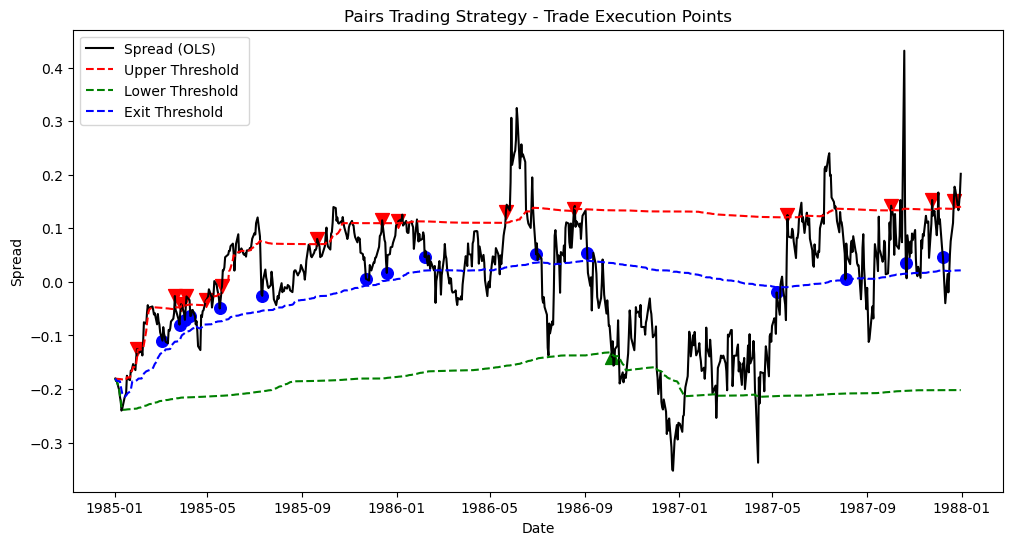

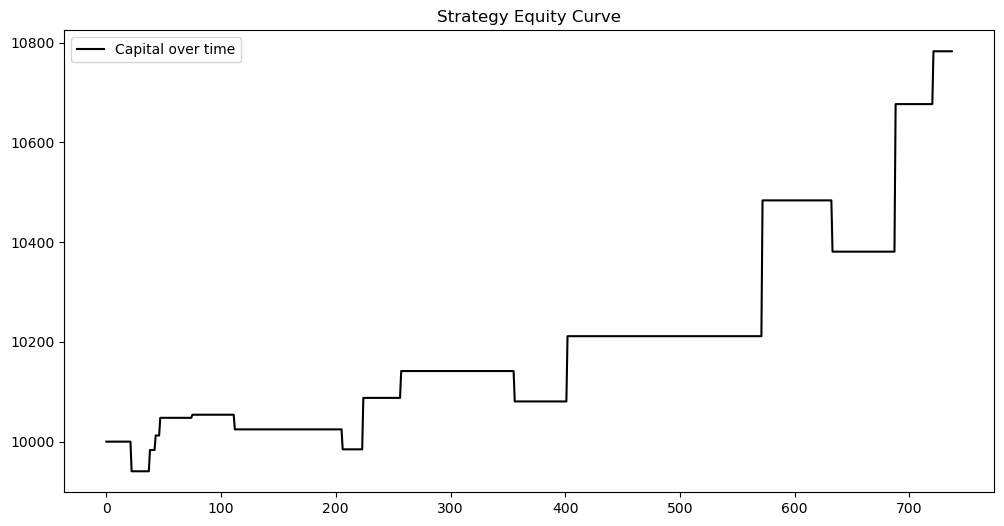

In [194]:
TradeSimulator(data,["OLS","QT"])

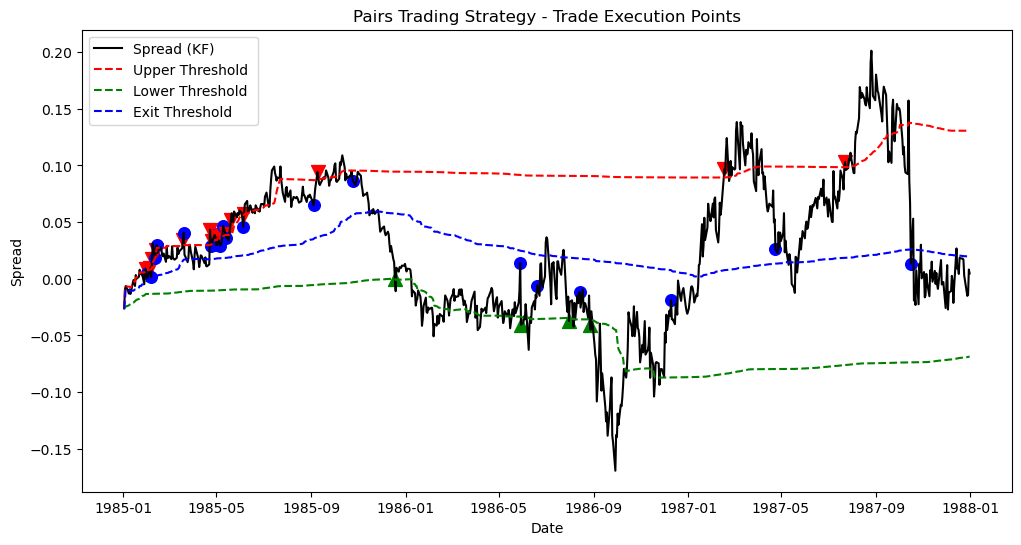

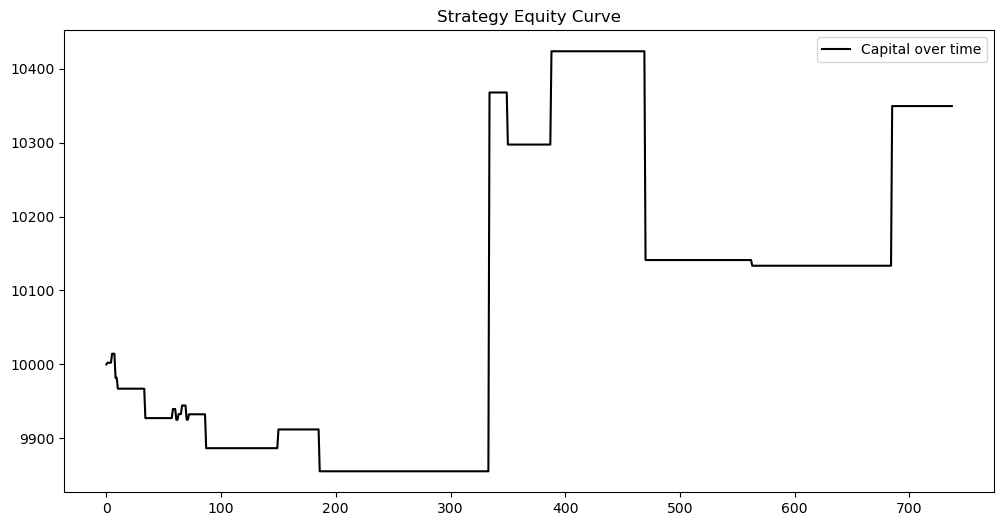

In [195]:
TradeSimulator(data,["KF","QT"])